<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E3%83%9E%E3%83%8F%E3%83%A9%E3%83%8E%E3%83%93%E3%82%B9%E8%B7%9D%E9%9B%A2%E3%81%A8%E3%82%AB%E3%82%A4%E4%BA%8C%E4%B9%97%E5%88%86%E5%B8%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# マハラノビス距離による異常検知（初心者向け・1セル版）
# 手順:
# 1) 相関あり2次元ガウスから学習用の「正常」データを作成
# 2) テスト用に「正常＋異常」を混ぜたデータを作成
# 3) 学習データから平均・共分散を推定
# 4) マハラノビス距離²を計算し、χ²分布のしきい値で異常判定
# 5) 可視化（元空間の散布図＋楕円、D²ヒストグラム）

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [ ]:
# 再現性があるようにランダムシードを固定
np.random.seed(0)

In [ ]:
# ===== 1) 学習データ（正常）と 2) テストデータ（正常＋異常） =====
mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0],
                  [2.0, 5.0]])   # 非直交（相関あり）

train = np.random.multivariate_normal(mu, Sigma, size=400)      # 学習：正常のみ
test_norm = np.random.multivariate_normal(mu, Sigma, size=200)  # テスト：正常

# 異常は平均を大きくずらす（分かりやすくするため）
mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2],
                      [0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=20)

test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])  # 0=正常,1=異常(真)

In [ ]:
# ===== 3) 学習データから平均・共分散を推定 =====
mu_hat = train.mean(axis=0)
Sigma_hat = np.cov(train, rowvar=False)
Sigma_inv = np.linalg.inv(Sigma_hat)


In [ ]:
# ===== 4) マハラノビス距離²の計算＆しきい値で判定 =====
def mahalanobis_sq(X, mu, Sigma_inv):
    diff = X - mu
    return np.einsum('ij,jk,ik->i', diff, Sigma_inv, diff)  # 各点ごとに (x-mu)^T Σ^{-1} (x-mu)

D2 = mahalanobis_sq(test, mu_hat, Sigma_inv)

alpha = 0.99      # 危険率1%（上側1%）に相当する信頼水準
df = 2            # 次元数
thr = chi2.ppf(alpha, df=df)   # 例: df=2, α=0.99 → 約 9.21
pred = (D2 > thr).astype(int)  # しきい値超えを「異常」と判定

# 簡単な集計
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0

print(f"chi-square threshold (alpha={alpha}, df={df}): {thr:.3f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

chi-square threshold (alpha=0.99, df=2): 9.210
TP=20, FP=3, FN=0
precision=0.870, recall=1.000


In [ ]:
# ===== 5) 可視化 =====
# (a) 元空間の散布図＋χ²等確率楕円
def chi2_ellipse(mu, Sigma, level=alpha, n=300):
    c = chi2.ppf(level, df=2)              # χ²分位点
    vals, vecs = np.linalg.eigh(Sigma)     # 固有分解（楕円の向き・長さ）
    t = np.linspace(0, 2*np.pi, n)
    circle = np.vstack([np.cos(t), np.sin(t)])
    radii = np.sqrt(vals * c)              # 半径 = sqrt(固有値 * c)
    ellipse = vecs @ np.diag(radii) @ circle
    return ellipse.T + mu

ell = chi2_ellipse(mu_hat, Sigma_hat, level=alpha)

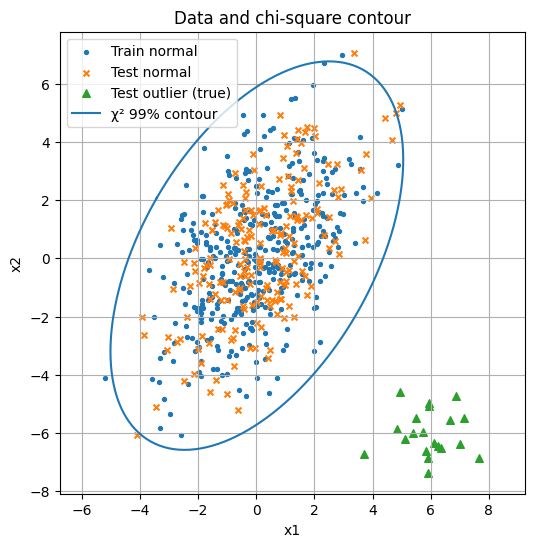

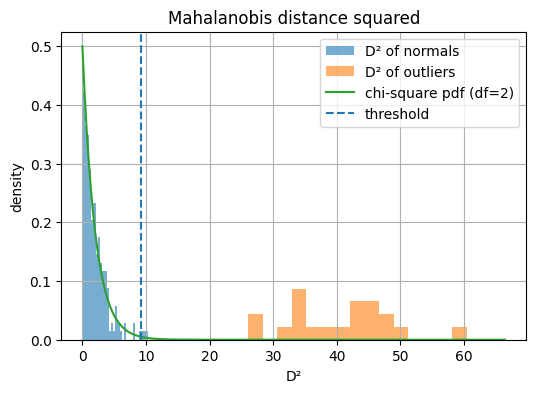

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(train[:,0],     train[:,1],     s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")
plt.plot(ell[:,0], ell[:,1], label=f"χ² {int(alpha*100)}% contour")
plt.title("Data and chi-square contour")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(); plt.grid(True); plt.axis('equal')
plt.show()

# (b) D² のヒストグラム（正常と異常を別表示）＋しきい値線
plt.figure(figsize=(6,4))
plt.hist(D2[labels==0], bins=30, density=True, alpha=0.6, label="D² of normals")
plt.hist(D2[labels==1], bins=15, density=True, alpha=0.6, label="D² of outliers")
x = np.linspace(0, D2.max()*1.1, 400)
plt.plot(x, chi2.pdf(x, df), label="chi-square pdf (df=2)")
plt.axvline(thr, linestyle='--', label="threshold")
plt.xlabel("D²"); plt.ylabel("density")
plt.title("Mahalanobis distance squared")
plt.legend(); plt.grid(True)
plt.show()
